In [25]:
import pandas as pd
import numpy as np
import tabulate as tab
import plotnine as p9
import mizani.formatters as mizani
import datetime
import re


import warnings
warnings.filterwarnings('ignore')

# in seconds
TIMEOUT = 100
TIMEOUT_VAL = TIMEOUT #* 1.1
TIME_MIN = 0.01

# table to LaTeX file
def table_to_file(table, headers, out_file):
    with open(f"./{out_file}.tex", mode='w') as fl:
        print(tab.tabulate(table, headers=headers, tablefmt="latex"), file=fl)

def read_file_filtered(filename, filter_func):
    """Reads a CSV file into Panda's data frame using a filter function"""
    df_loc = pd.read_csv(
        filename,
        sep=";",
        comment="#",
        )
    df_loc["filename"] = filename
    df_loc = filter_func(df_loc)
    return df_loc

# For printing scatter plots
def scatter_plot(df, xcol, ycol, domain, xname=None, yname=None, log=False, width=6, height=6, clamp=True, tickCount=5):
    assert len(domain) == 2

    POINT_SIZE = 3.0
    DASH_PATTERN = (0, (6, 2))

    if xname is None:
        xname = xcol
    if yname is None:
        yname = ycol

    # formatter for axes' labels
    ax_formatter = mizani.custom_format('{:n}')

    if clamp:  # clamp overflowing values if required
        df = df.copy(deep=True)
        df.loc[df[xcol] > domain[1], xcol] = domain[1]
        df.loc[df[ycol] > domain[1], ycol] = domain[1]

    # generate scatter plot
    scatter = p9.ggplot(df)
    scatter += p9.aes(x=xcol, y=ycol, color="benchmark")
    scatter += p9.geom_point(size=POINT_SIZE, na_rm=True)
    scatter += p9.labs(x=xname, y=yname)
    scatter += p9.theme(legend_key_width=2)
    scatter += p9.scale_color_hue(l=0.4, s=0.9, h=0.1)

    # rug plots
    scatter += p9.geom_rug(na_rm=True, sides="tr", alpha=0.05)

    if log:  # log scale
        scatter += p9.scale_x_log10(limits=domain, labels=ax_formatter)
        scatter += p9.scale_y_log10(limits=domain, labels=ax_formatter)
    else:
        scatter += p9.scale_x_continuous(limits=domain, labels=ax_formatter)
        scatter += p9.scale_y_continuous(limits=domain, labels=ax_formatter)

    # scatter += p9.theme_xkcd()
    scatter += p9.theme_bw()
    scatter += p9.theme(panel_grid_major=p9.element_line(color='#666666', alpha=0.5))
    scatter += p9.theme(panel_grid_minor=p9.element_blank())
    scatter += p9.theme(figure_size=(width, height))
    scatter += p9.theme(axis_text=p9.element_text(size=24, color="black"))
    scatter += p9.theme(axis_title=p9.element_text(size=24, color="black"))
    scatter += p9.theme(legend_text=p9.element_text(size=12))

    # generate additional lines
    scatter += p9.geom_abline(intercept=0, slope=1, linetype=DASH_PATTERN)  # diagonal
    scatter += p9.geom_vline(xintercept=domain[1], linetype=DASH_PATTERN)  # vertical rule
    scatter += p9.geom_hline(yintercept=domain[1], linetype=DASH_PATTERN)  # horizontal rule

    scatter += p9.theme(legend_position='bottom')
    scatter += p9.theme(legend_position="none")#remove legend

    res = scatter

    return res


def table_runover(df, file_suffix):
    runtime_columns = [col for col in df.columns if "runtime" in col]

    # Replace "TO" and "ERR" values and convert columns to numeric
    df = df.replace("TO", 100.0).replace("ERR", np.nan)

    # Convert runtime columns to numeric
    for col in runtime_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Select runtime columns
    df_runtime = df[runtime_columns]

    rsaregex_col = "rsaregex-runtime"
    hybrid_columns = {}

    for col in runtime_columns:
        if col != rsaregex_col:
            hybrid_name = f"{col}+rsa"
            df[hybrid_name] = df[[rsaregex_col, col]].min(axis=1)
            hybrid_columns[hybrid_name] = df[hybrid_name]

    # Merge hybrid tools into df_runtime
    df_runtime = pd.concat([df_runtime] + list(hybrid_columns.values()), axis=1)

    # Compute summary statistics
    stats = df_runtime.describe().T  # Transpose for easier access
    counts = df_runtime.count()

    # Compute thresholds
    under_1s = (df_runtime <= 1).sum()
    over_1s = (df_runtime > 1).sum()
    over_5s = (df_runtime > 5).sum()
    over_10s = (df_runtime > 10).sum()
    over_50s = (df_runtime > 50).sum()
    timeouts = (df_runtime >= 100).sum()

    # Prepare the data for table display
    table_data = []
    for tool in runtime_columns:
        table_data.append([
            tool.removesuffix('-runtime'),  # Tool name
            #f"{stats.loc[tool, 'mean']:.2f}",  # Mean
            #f"{stats.loc[tool, 'std']:.2f}",  # Std dev
            f"{under_1s[tool]}" + (f" ({under_1s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            #f"{over_05s[tool]}" + (f" ({over_05s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{over_1s[tool]}" + (f" ({over_1s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{over_5s[tool]}" + (f" ({over_5s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{over_10s[tool]}"+ (f" ({over_10s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{over_50s[tool]}"+ (f" ({over_50s[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{timeouts[tool]}"+ (f" ({timeouts[tool+'+rsa']})" if tool != 'rsaregex-runtime' else ""),
            f"{len(df) - counts[tool]}" + (f" ({len(df) - counts[tool+'+rsa']})" if tool != 'rsaregex-runtime' else "")
        ])

    # Headers
    headers = ["Tool", "< 1", "> 1 s", "> 5 s", "> 10 s", "> 50 s", "> 100 s (TOs)", "Errors"]

    print(tab.tabulate(table_data, headers=headers, tablefmt="github"))
    table_to_file(table_data, headers, "table1"+file_suffix)


# generate evaluation
def gen_evaluation(df, main_tool, all_tools, file_suffix = "", toolname = "rsamatch"):

    print(f"time:  {datetime.datetime.now()}")
    print(f"# of attacks: {len(df)}")

    table_runover(df, file_suffix)

    summary_times = dict()
    for col in df.columns:
        if re.search('-result$', col):
            summary_times[col] = dict()
            #summary_times[col]['timeouts'] = df[col].isna().sum()
            summary_times[col]['timeouts'] = (df[col] == 'TO').sum()
            summary_times[col]['errors'] = (df[col] == 'ERR').sum()
            #df[col] = df[col].str.strip()
            summary_times[col]['unknowns'] = df[df[col] == "unknown"].shape[0] #[df[col] == "unknown"].shape[0]

    for col in df.columns:
        if re.search('-runtime$', col):
            #df[col] = df[col].replace(['TO', 'ERR', 'MISSING'], np.nan)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            summary_times[col] = dict()
            summary_times[col]['max'] = df[col].max()
            summary_times[col]['min'] = df[col].min()
            summary_times[col]['mean'] = df[col].mean()
            summary_times[col]['median'] = df[col].median()
            summary_times[col]['std'] = df[col].std()

    df_summary_times = pd.DataFrame(summary_times).transpose()
    tab_interesting = []
    for i in all_tools:
        row = df_summary_times.loc[i + '-runtime']
        unknown_row = dict(df_summary_times.loc[i + '-result'])
        row_dict = dict(row)
        row_dict.update({'name': i})
        tab_interesting.append([row_dict['name'],
                                # row_dict['min'],
                                row_dict['max'],
                                row_dict['mean'],
                                row_dict['median'],
                                row_dict['std'],
                                unknown_row['timeouts'],
                                unknown_row['errors'],
                                unknown_row["unknowns"]])

    headers = ["method", "max", "mean", "median", "std. dev", "timeouts", "errors", "unknowns"]
    print("###################################################################################")
    print("####                                   Table 1                                 ####")
    print("###################################################################################")
    print(tab.tabulate(tab_interesting, headers=headers, tablefmt="github"))
    print("\n\n")

    # sanitizing NAs
    for col in df.columns:
        if re.search('-runtime$', col):
            df[col].fillna(TIMEOUT_VAL, inplace=True)
            df.loc[df[col] < TIME_MIN, col] = TIME_MIN  # to remove 0 (in case of log graph)


    # scatter plots
    to_cmp2 = []
    for t in all_tools:
      if t == main_tool:
        continue
      to_cmp2.append({'x': main_tool, 'y': t,
                'xname': RSAREGEX, 'yname': t,
                'max': TIMEOUT_VAL, 'tickCount': 3})
      
    for params in to_cmp2:
        if 'xname' not in params:
            params['xname'] = None
        if 'yname' not in params:
            params['yname'] = None
        if 'max' not in params:
            params['max'] = TIMEOUT_VAL
        if 'tickCount' not in params:
            params['tickCount'] = 5
        if 'filename' not in params:
            #params['filename'] = "./" + params['x'] + "_vs_" + params['y'] + file_suffix + ".pdf"
            params['filename'] = "./" + "vs_" + params['y'] + file_suffix + ".pdf"
    size = 7
    plot_list = [(params['x'],
                  params['y'],
                  params['filename'],
                  scatter_plot(df,
                               xcol=params['x'] + '-runtime',
                               ycol=params['y'] + '-runtime',
                               xname=toolname, yname=params['yname'],
                               domain=[TIME_MIN, params['max']],
                               tickCount=params['tickCount'],
                               log=True, width=size, height=size)) for params
                 in to_cmp2]

    print("\n\n")
    print("Generating plots...")
    for x, y, filename, plot in plot_list:
        #filename = f"plots/{out_prefix}_{filename}.pdf"
        print(f"plotting x: {x}, y: {y}... saving to {filename}")
        # plot.save(filename, scale_factor=2)
        plot.save(filename=filename, dpi=1000)
        plot.show()

In [26]:
RSAREGEX = "rsaregex"

TOOLS = [
    RSAREGEX,
    ### OTHER TOOLS ###
    "grep",
    "re",
    "pcre2",
    "js",
    "java",
    "net",
    "oldrsa",
]

FILES = [
    "lf.csv",
    "rengar.csv"
]

def get_df_all(filter_func = (lambda x: x)):
  """Load files into a df_all for evaluation while optionally filtering"""
  dfs = dict()
  for file in FILES:
    df = read_file_filtered(file, filter_func)
    df["benchmark"] = file
    dfs[file] = df
  df_all = pd.concat(dfs)[["name"] + [f(tool) for tool in TOOLS for f in (lambda x: x+"-result", lambda x: x+"-runtime")] + ["benchmark"]]
  return df_all

def matchtime(df_loc):
  df_loc['rsaregex-runtime'] = df_loc['rsaregex-matchtime']
  df_loc['oldrsa-runtime'] = df_loc['oldrsa-matchtime']
  return df_loc


df_all_det = get_df_all()
df_all_mt = get_df_all(matchtime)

time:  2025-10-28 18:29:30.791021
# of attacks: 1330
| Tool     | < 1         | > 1 s     | > 5 s    | > 10 s   | > 50 s   | > 100 s (TOs)   | Errors   |
|----------|-------------|-----------|----------|----------|----------|-----------------|----------|
| rsaregex | 769         | 518       | 62       | 54       | 42       | 41              | 43       |
| grep     | 1192 (1298) | 48 (24)   | 42 (18)  | 41 (16)  | 25 (14)  | 18 (11)         | 90 (8)   |
| re       | 1208 (1296) | 122 (34)  | 84 (15)  | 70 (15)  | 58 (12)  | 55 (12)         | 0 (0)    |
| pcre2    | 1078 (1319) | 26 (11)   | 11 (6)   | 7 (6)    | 3 (6)    | 3 (6)           | 226 (0)  |
| js       | 710 (874)   | 66 (454)  | 58 (42)  | 57 (38)  | 45 (31)  | 44 (31)         | 554 (2)  |
| java     | 634 (835)   | 64 (483)  | 45 (44)  | 40 (40)  | 33 (33)  | 28 (32)         | 632 (12) |
| net      | 671 (861)   | 109 (467) | 77 (42)  | 64 (38)  | 54 (31)  | 51 (31)         | 550 (2)  |
| oldrsa   | 421 (769)   | 903 (555) |

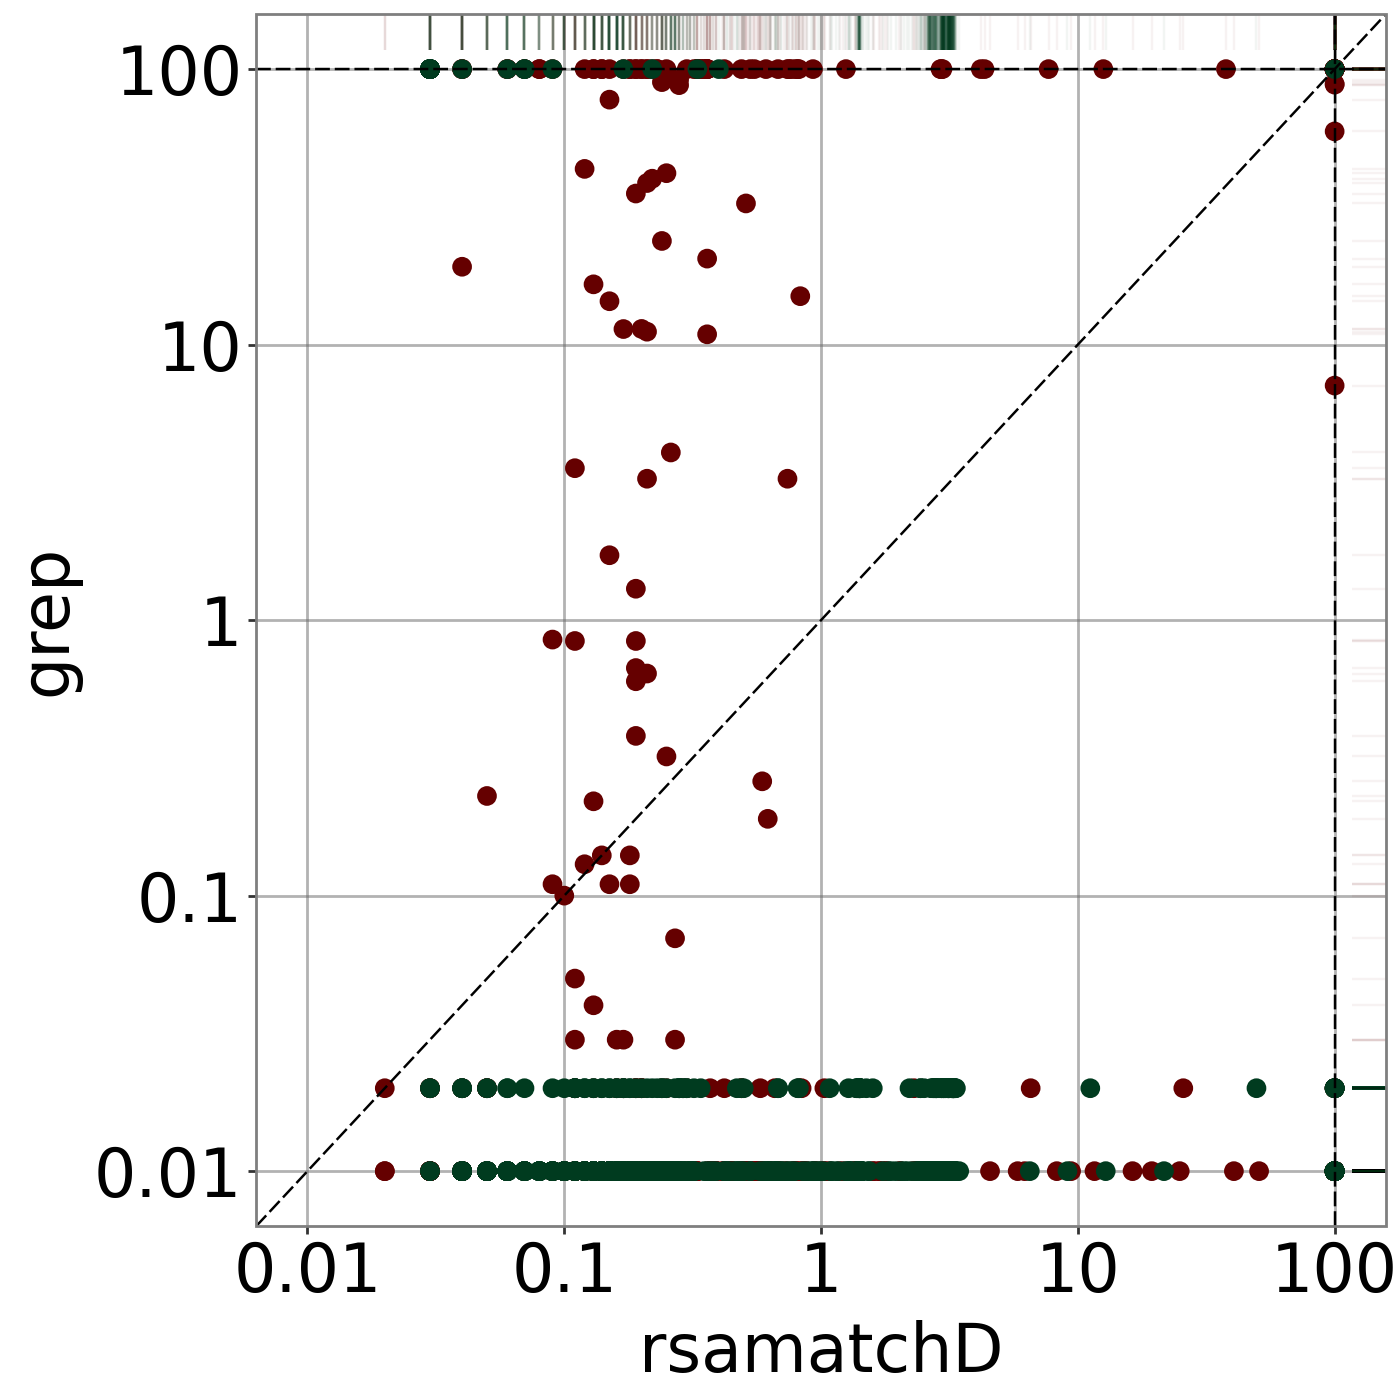

plotting x: rsaregex, y: re... saving to ./vs_re.pdf


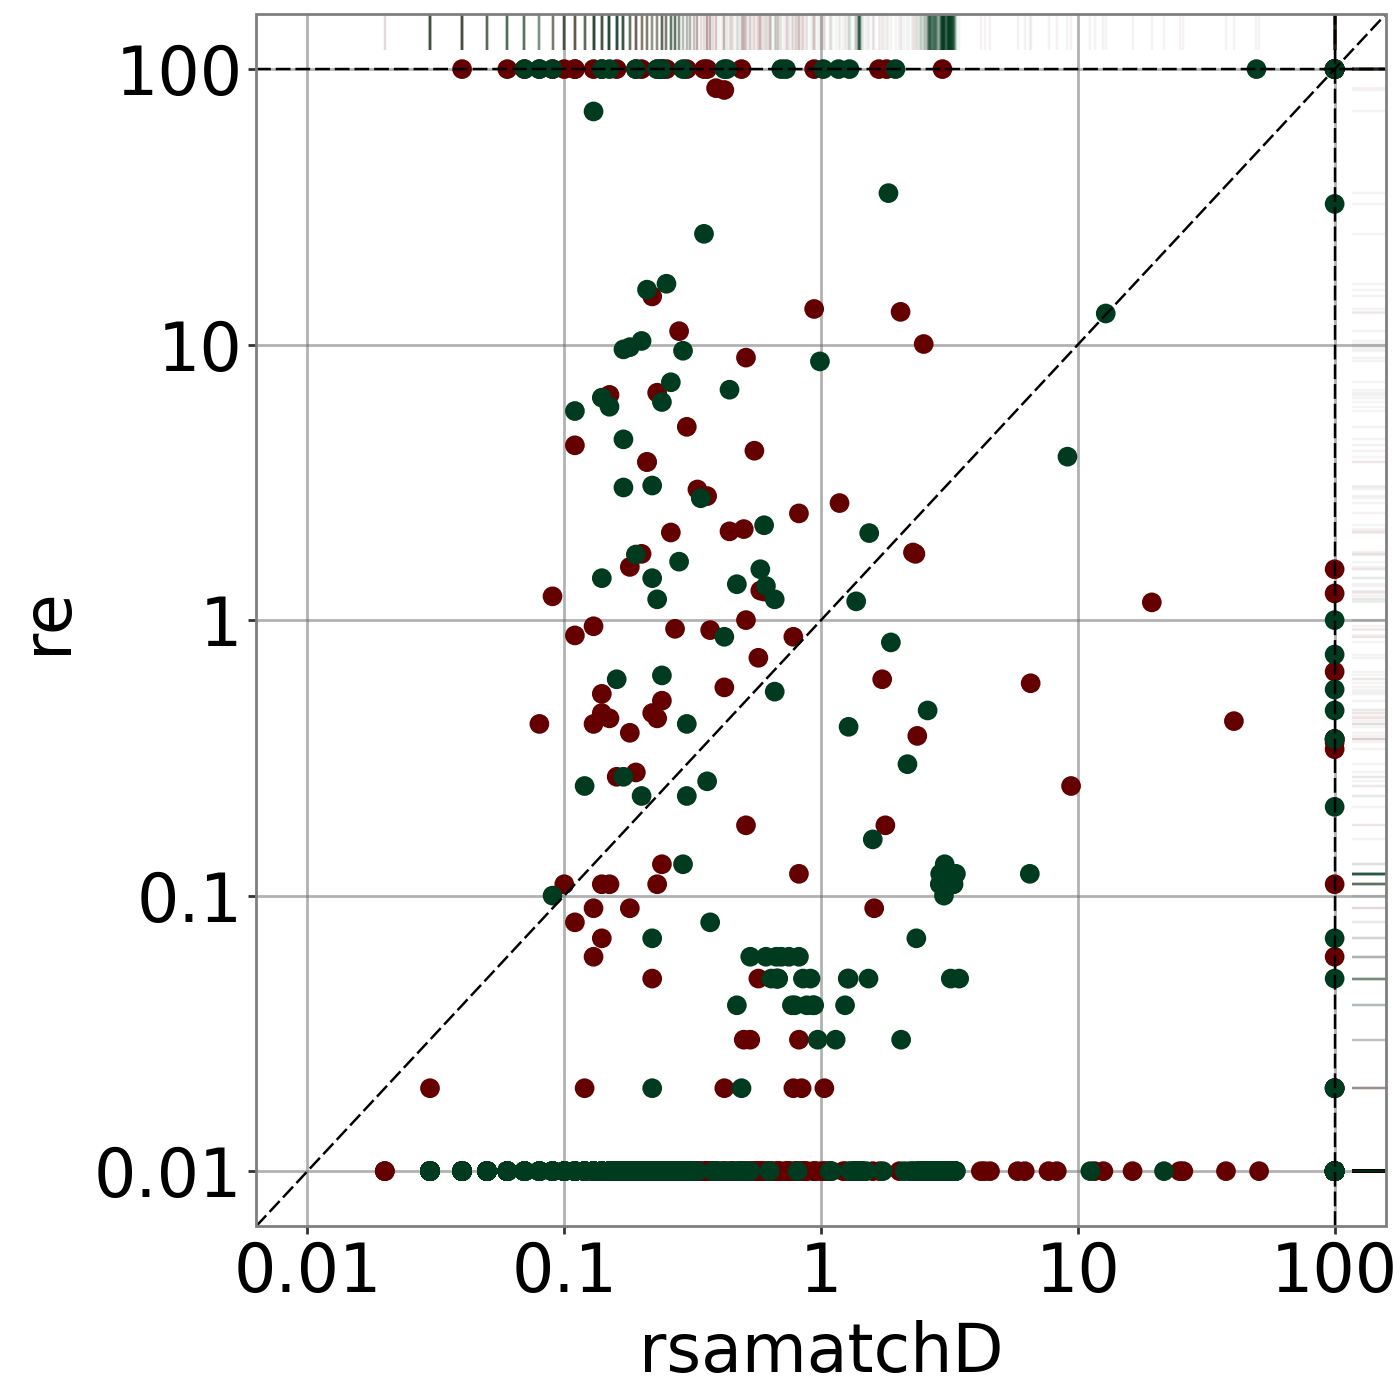

plotting x: rsaregex, y: pcre2... saving to ./vs_pcre2.pdf


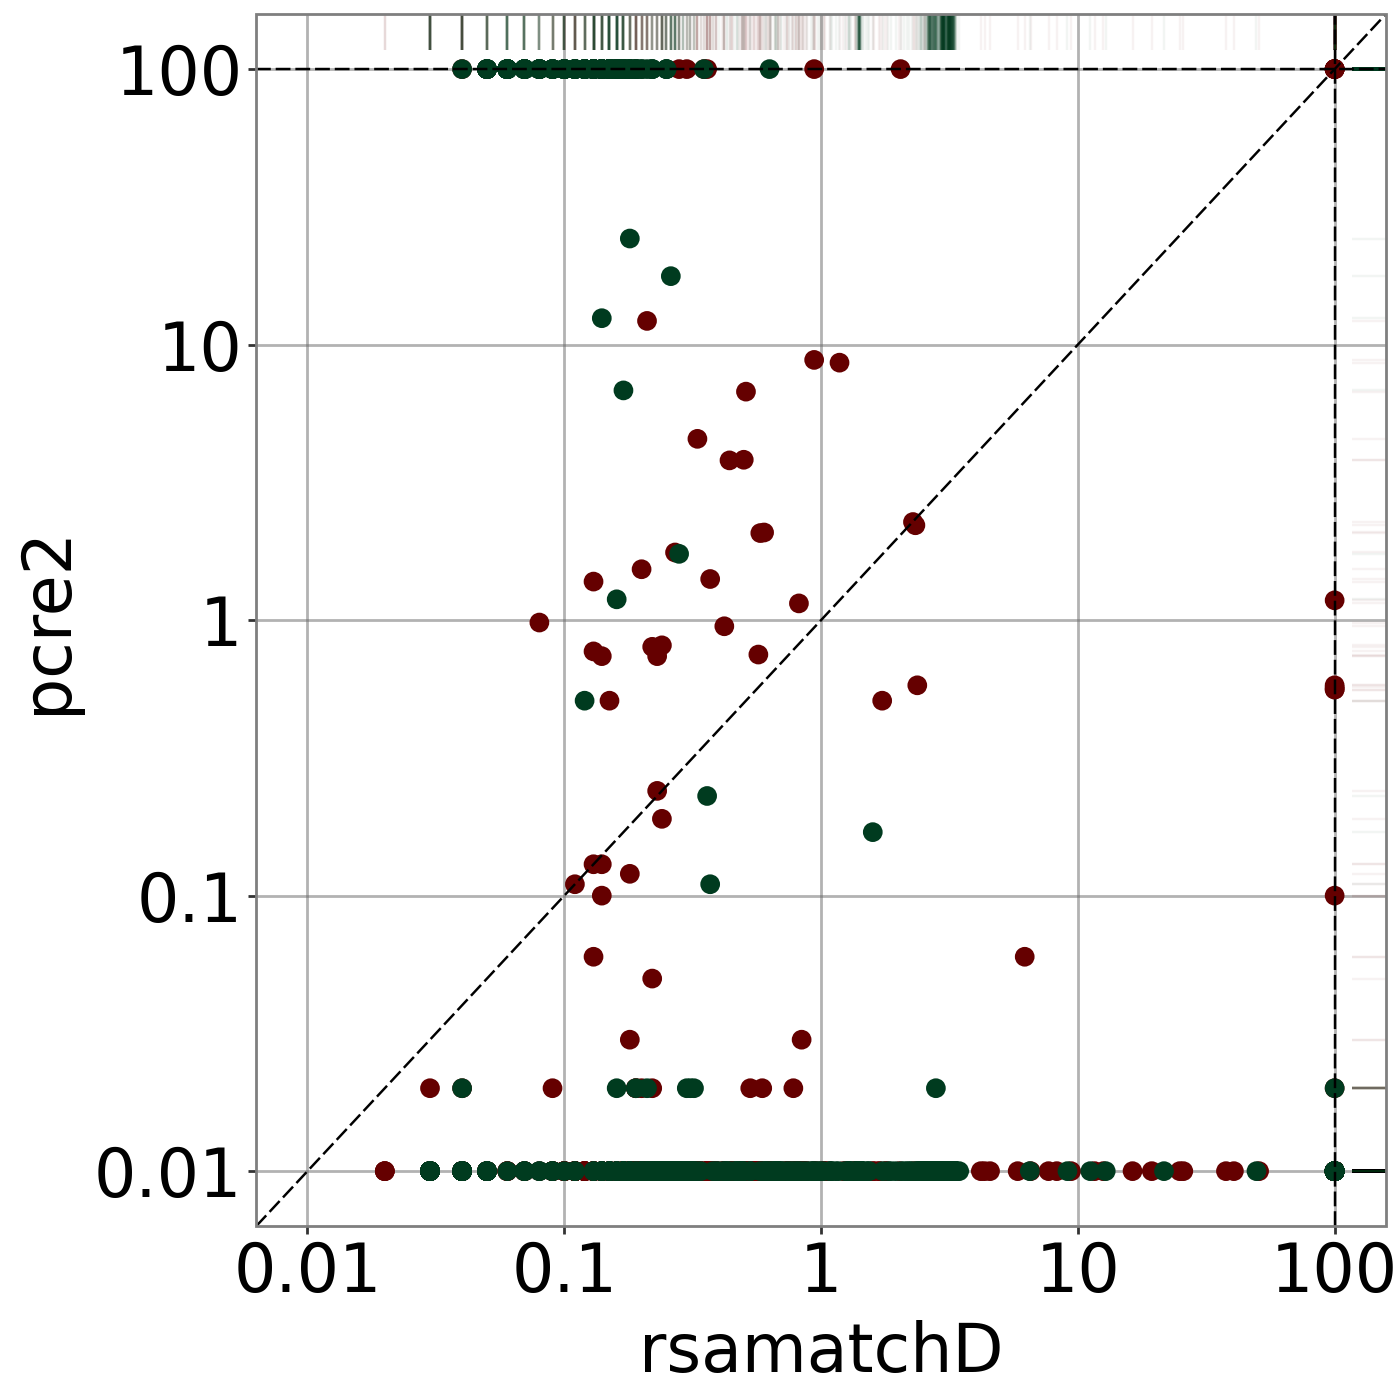

plotting x: rsaregex, y: js... saving to ./vs_js.pdf


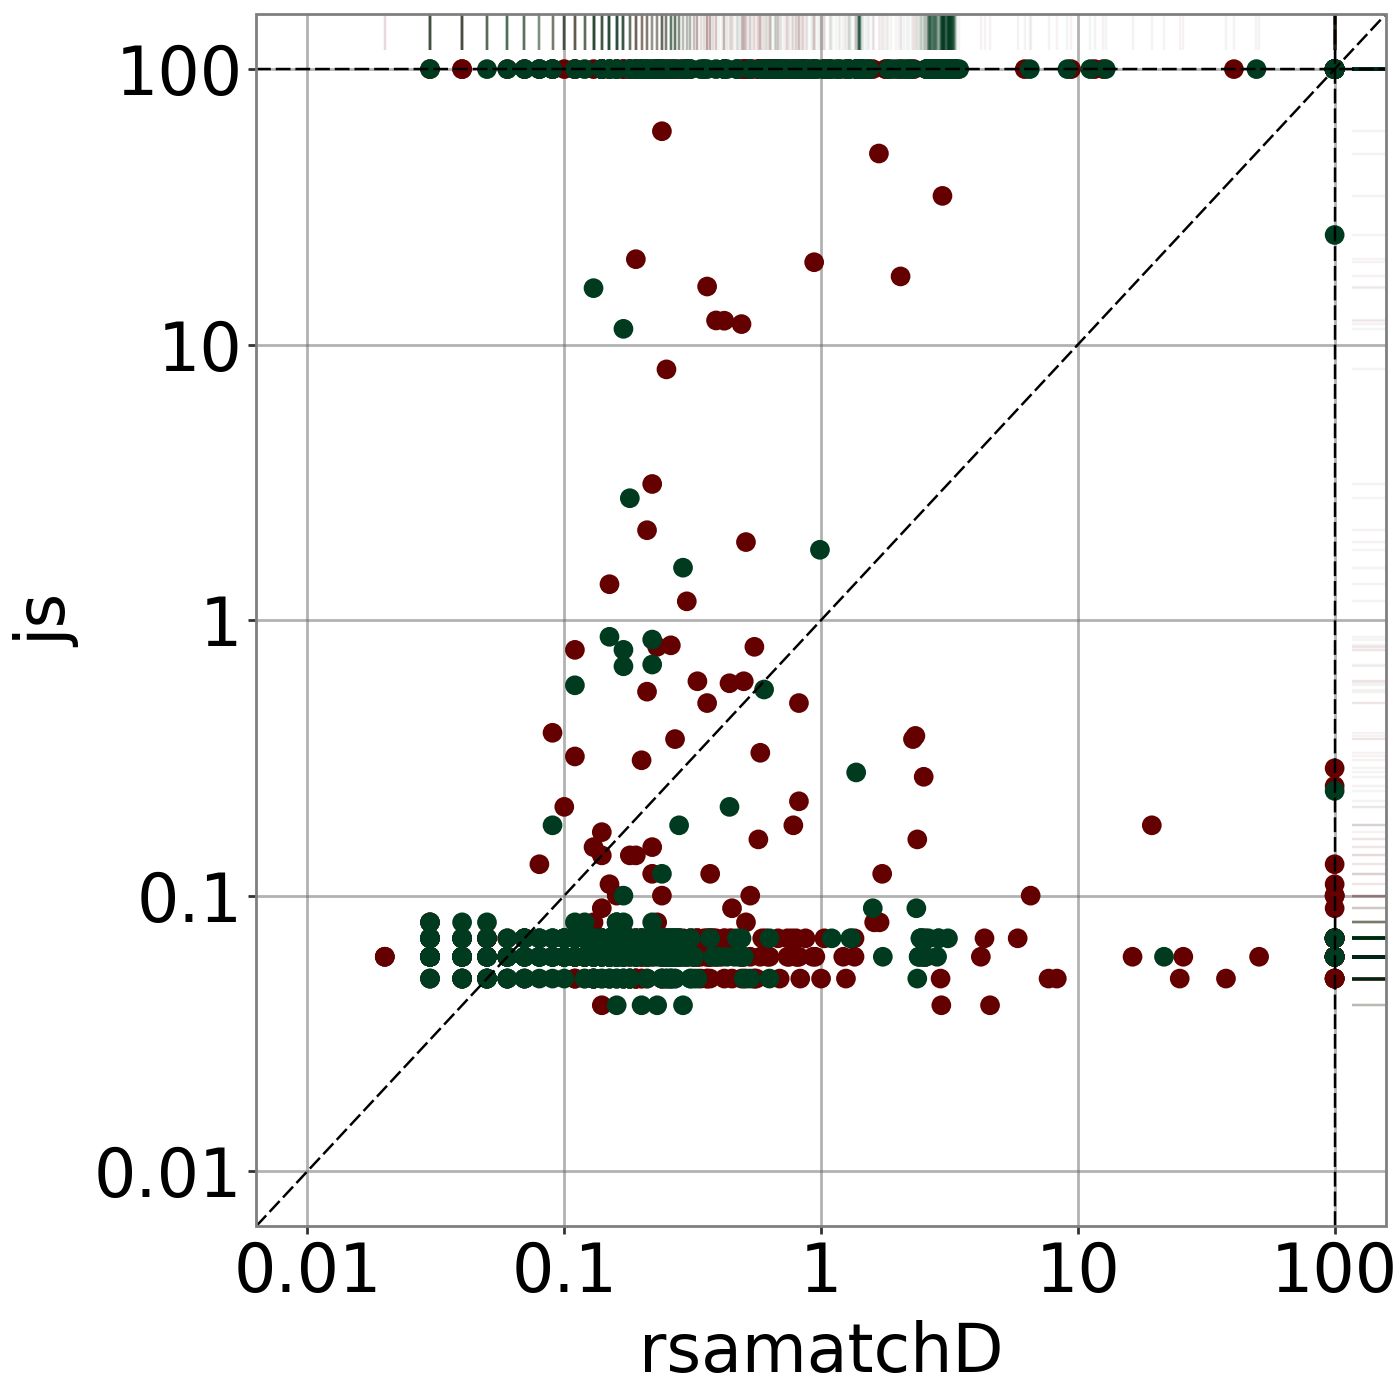

plotting x: rsaregex, y: java... saving to ./vs_java.pdf


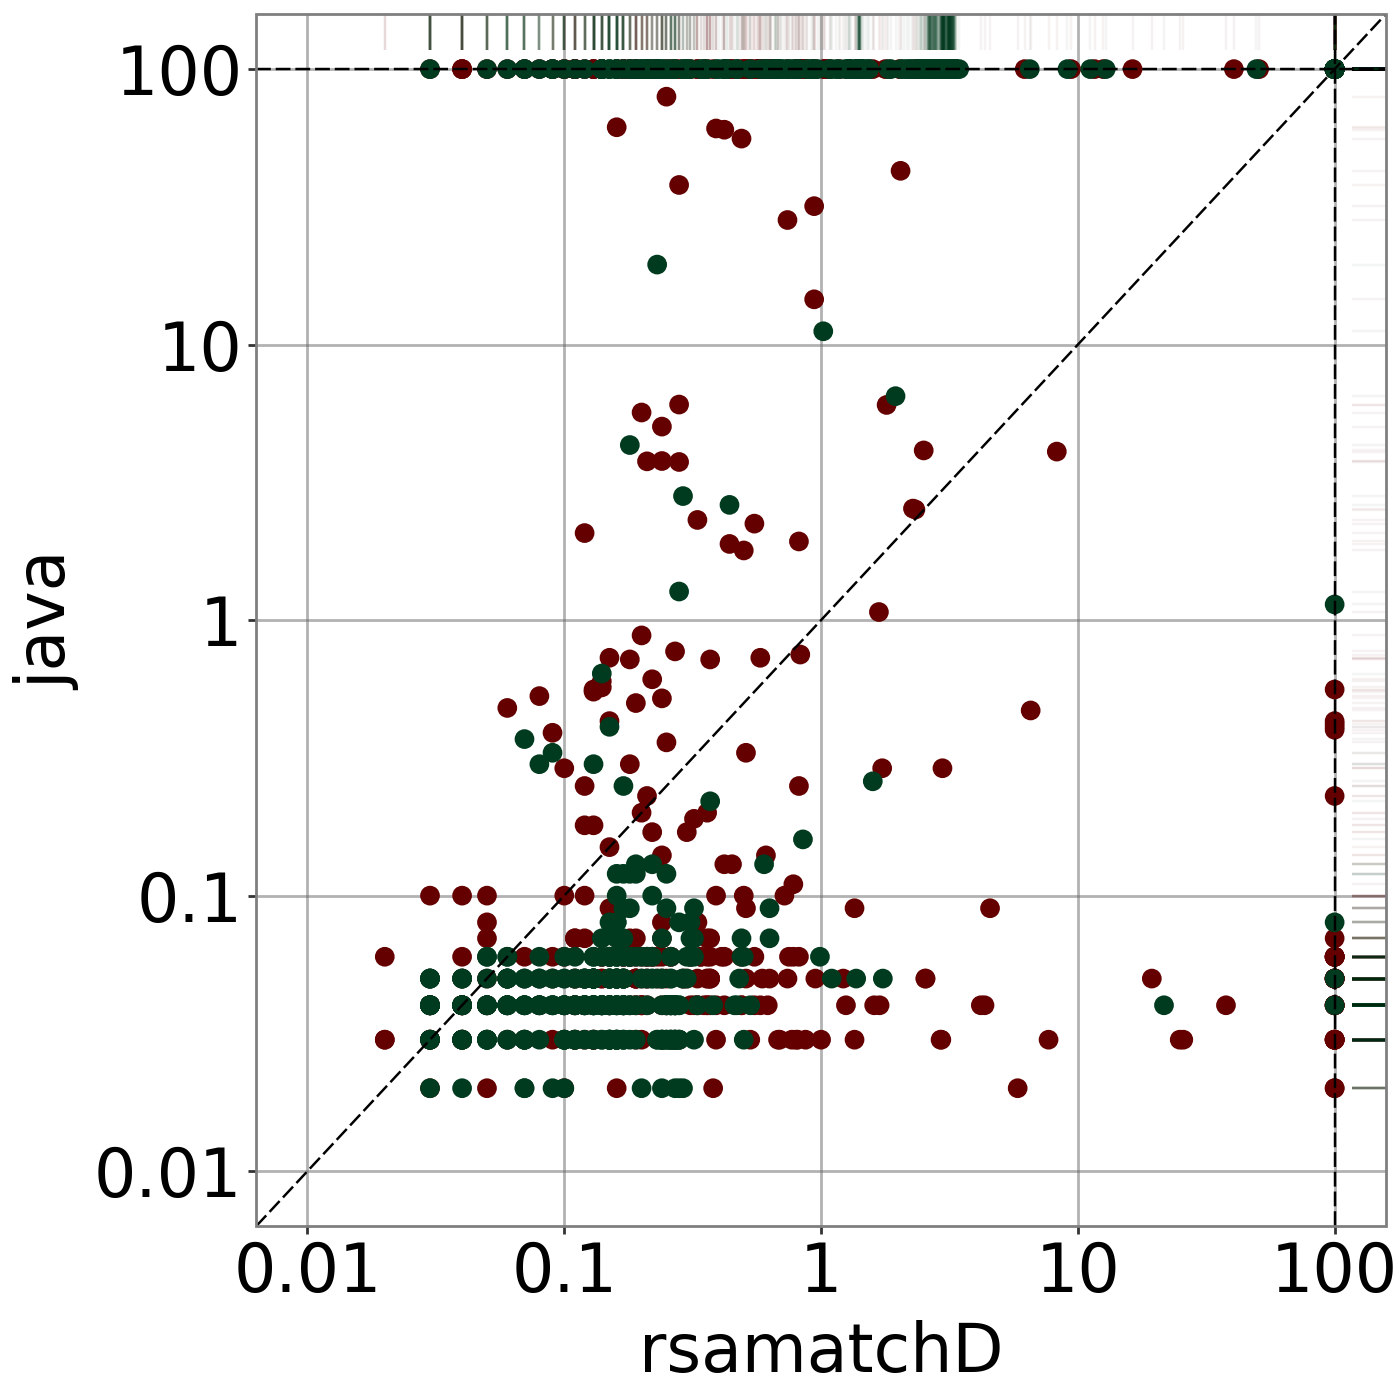

plotting x: rsaregex, y: net... saving to ./vs_net.pdf


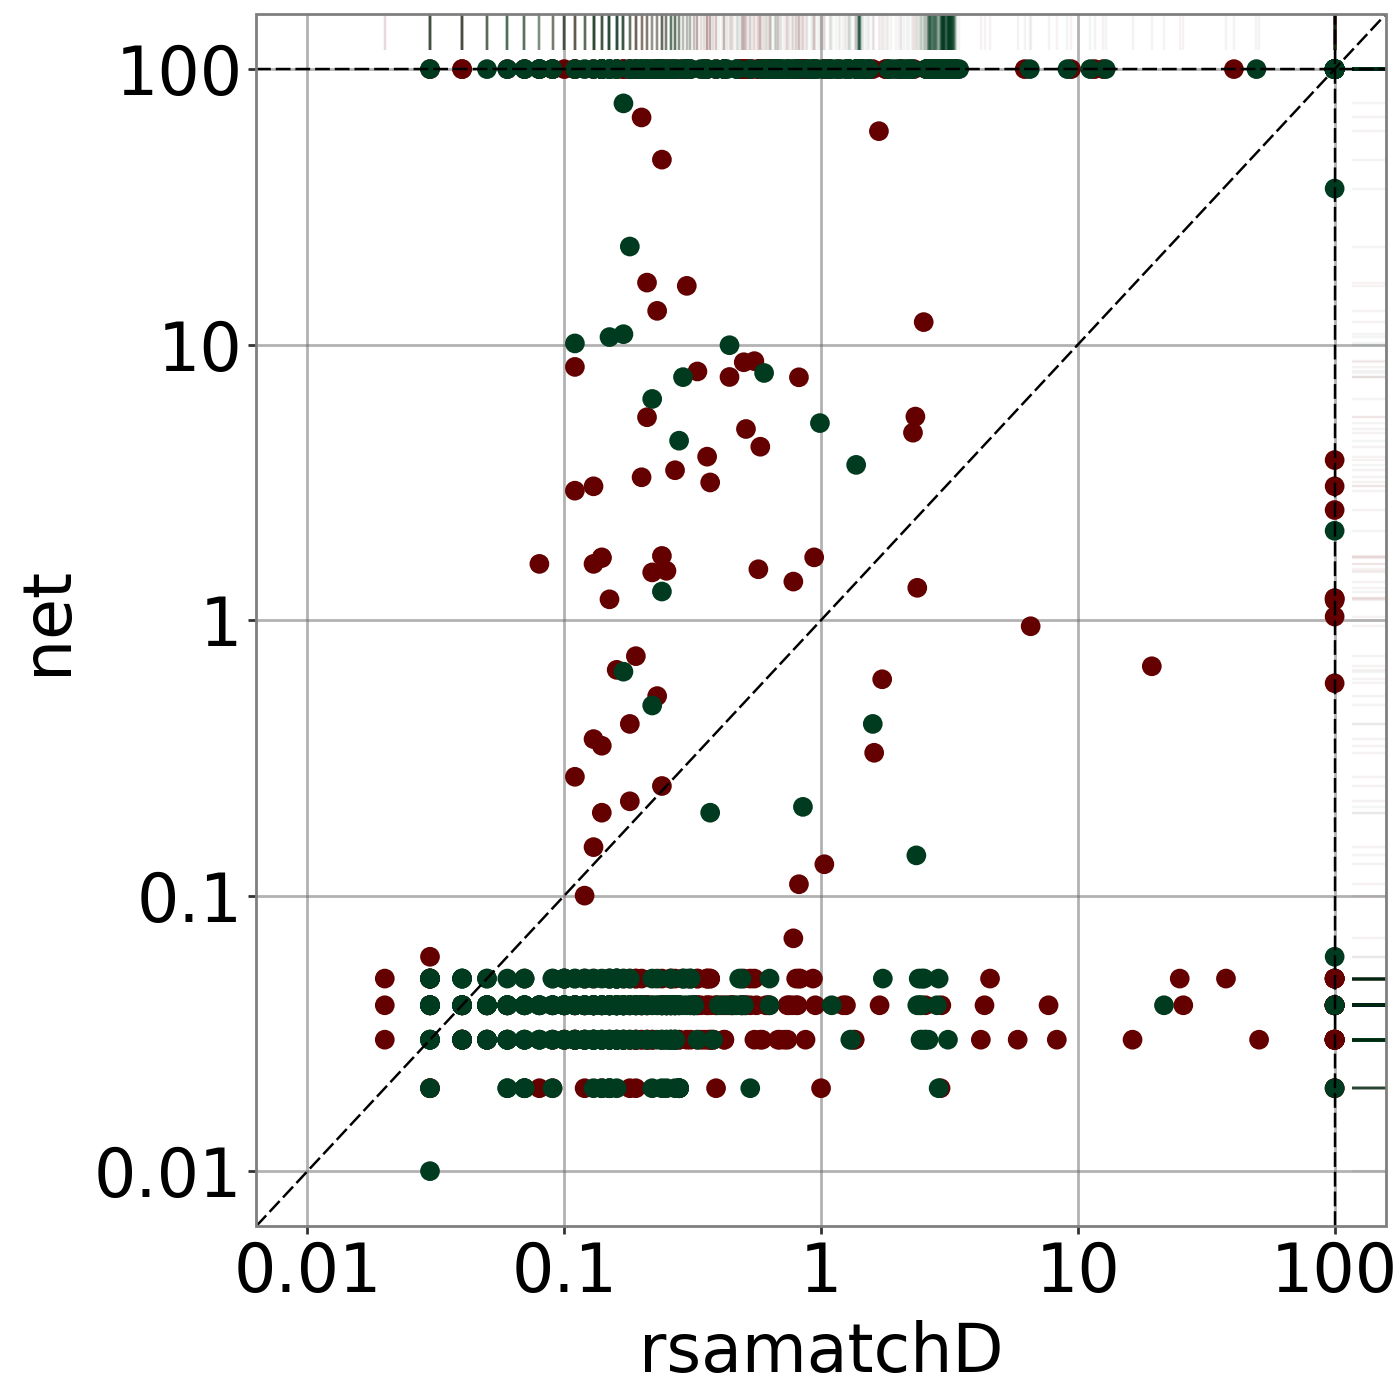

plotting x: rsaregex, y: oldrsa... saving to ./vs_oldrsa.pdf


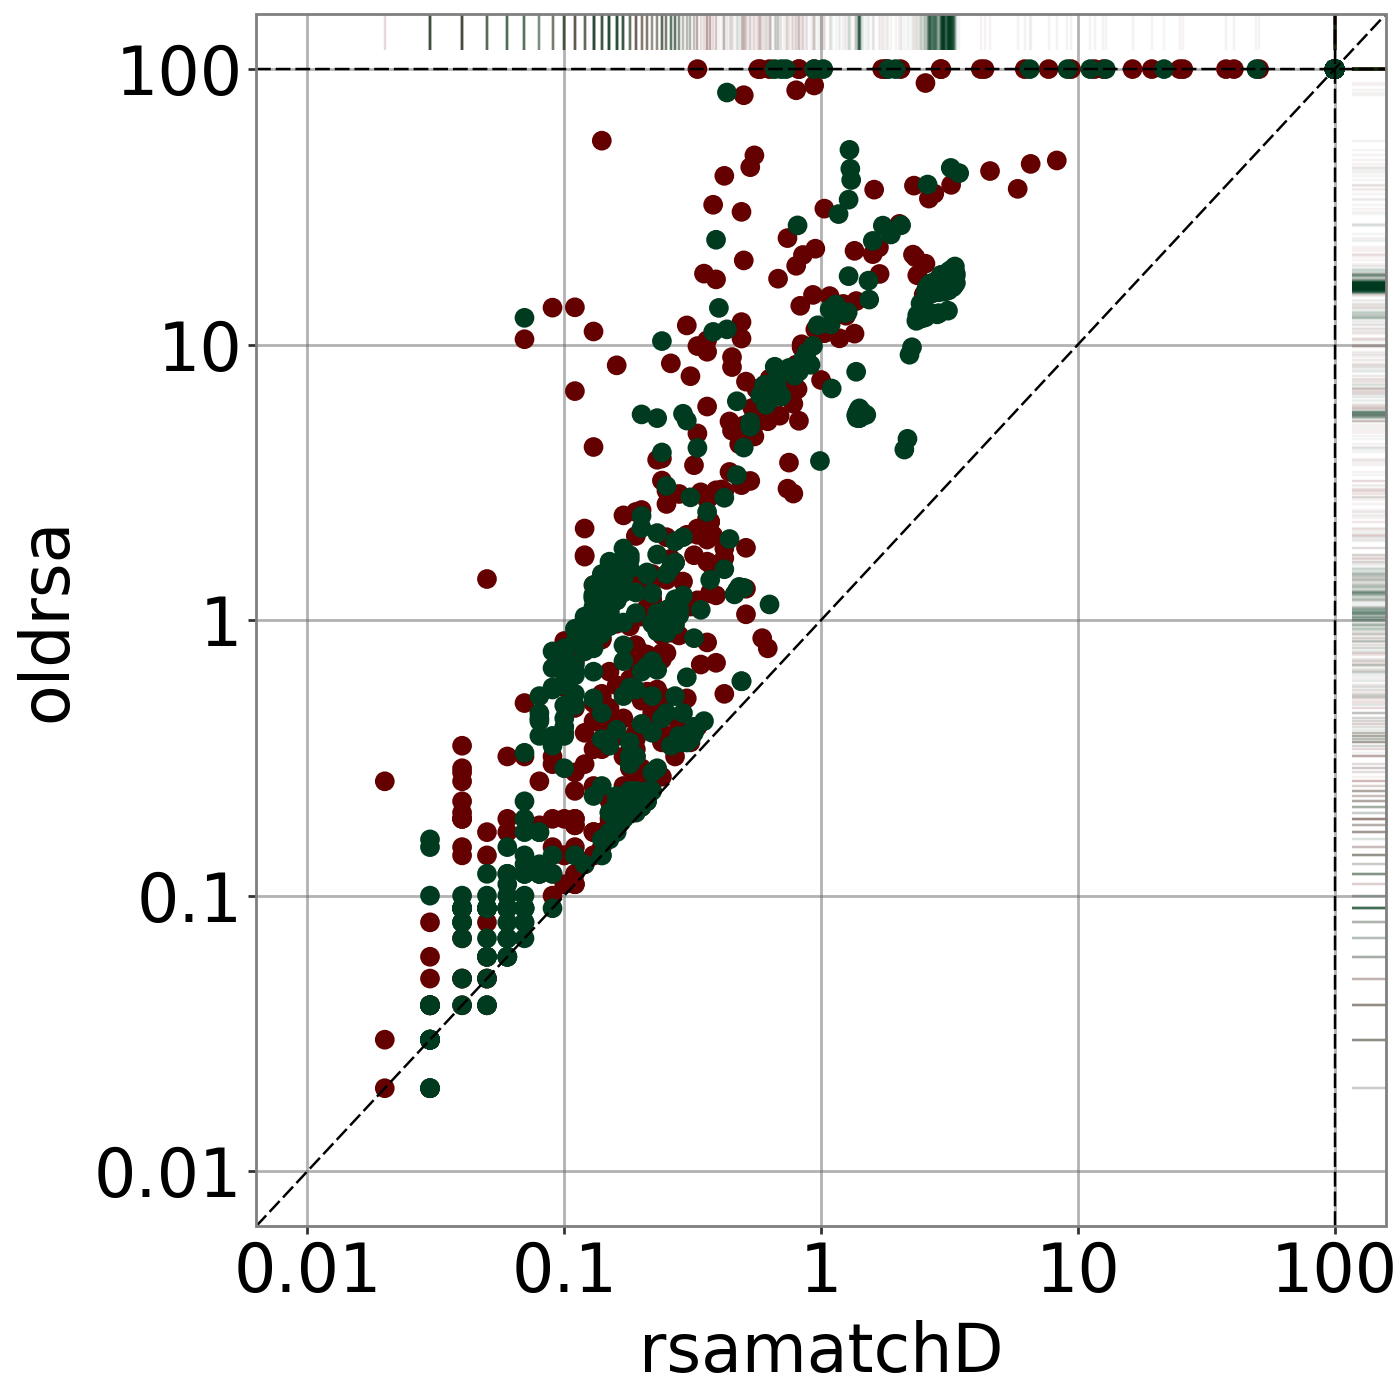

In [27]:
gen_evaluation(df_all_det, RSAREGEX, TOOLS, toolname="rsamatchD")

In [ ]:
gen_evaluation(df_all_mt, RSAREGEX, TOOLS, file_suffix="_m")